In [1]:
import psutil
print(psutil.virtual_memory())

svmem(total=8589934592, available=1757085696, percent=79.5, used=3090857984, free=282836992, active=1485144064, inactive=1268514816, wired=1605713920)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import time
import faiss
import webcolors

In [3]:
def display_images_and_titles(filepaths, titles):
    # Create a 3x5 grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory, df):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

    


In [4]:
def clip_search_image_and_text(path_to_image, text):
    
    #Import dataset
    filename ="./myntradataset/styles.csv" # Modify directory
    df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas
    
    #Data Wrangling
    available_ids = os.listdir("./myntradataset/images") # Modify directory
    available_ids = [int(x.replace(".jpg","")) for x in available_ids]
    df = df[df.id.isin(available_ids)] #some images are not actually available
    df=df.dropna(subset='productDisplayName')

    custom_image = Image.open(path_to_image)

    # Load model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") #Import CLIP Model
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    #Extract text and image embeddings 
    image_vectors = torch.load("image_tensor.pt") # Modify directory
    image_vectors_np = image_vectors.numpy()

    text_vectors = torch.load("title_tensor.pt") # Modify directory
    text_vectors_np = text_vectors.numpy()
    
    knn_labels = df.id.astype(str).tolist()

    # Build the index
    dimension = image_vectors_np.shape[1]  # Dimension of the vectors
    index_image = faiss.IndexFlatL2(dimension)
    index_image.add(image_vectors_np)

    # Preprocess the custom image and text 
    inputs = processor(text=text, images=custom_image, return_tensors="pt", padding=True)

    # Perform inference on the custom image and text
    outputs = model(**inputs)

    #knn for text 
    np_text_emb = outputs.text_embeds.detach().cpu().numpy() #Get text query embedding
    k_text= 6000 # Number of text neighbors to return
    D_text, I_text = index_image.search(np_text_emb.reshape(1, -1) , k_text)
    
    #knn for image
    np_image_emb = outputs.image_embeds.detach().cpu().numpy() #Get image query embedding
    k_image= 450 # Number of image neighbors to return
    D_image, I_image = index_image.search(np_image_emb.reshape(1, -1), k_image)

    #Find insersection of knn image and text results and change order
    common_elements, indices_arr1, indices_arr2 = np.intersect1d(I_image[0], I_text[0], assume_unique=True, return_indices=True)
    common_elements_ordered = [I_text[0][i] for i in np.sort(indices_arr2)]

    # Retrieve the corresponding labels 
    common_ids_ordered = [knn_labels[i] for i in common_elements_ordered]

    return common_ids_ordered, df

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") #Import CLIP Model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

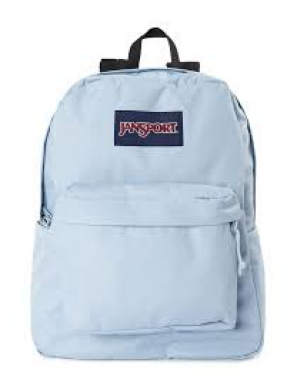

In [6]:
#Open the image
#image = Image.open('/Users/meagankenney/IMA Bootcamp/Ebay/Red_bag.jpeg')
#image = Image.open('/Users/meagankenney/IMA Bootcamp/Ebay/model_Test.png')
image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/VisualSearch/Survey_Images/blue_backpack.jpeg'
image = Image.open(image_path)
#What text do you want to attach
plt.imshow(image)
plt.axis('off')  # Remove the axis labels
plt.show()

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

#whereever you loaded your vit_h file
sam_checkpoint ="/Users/meagankenney/IMA Bootcamp/Ebay/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

predictor = SamPredictor(sam)

In [9]:
import cv2

def get_clicked_point(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Create a copy of the image for display
    display_image = image.copy()

    # Flag to indicate if a point has been captured
    point_captured = False

    # Variables to store the clicked coordinates
    clicked_x = None
    clicked_y = None

    def click_callback(event, x, y, flags, param):
        nonlocal point_captured, clicked_x, clicked_y

        # Check if the left mouse button is pressed
        if event == cv2.EVENT_LBUTTONDOWN and not point_captured:
            # Store the clicked coordinates
            clicked_x = x
            clicked_y = y

            # Print the coordinates
            print(f"Clicked coordinates: x={clicked_x}, y={clicked_y}")

            # Draw a circle at the clicked point
            cv2.circle(display_image, (clicked_x, clicked_y), 5, (0, 0, 255), -1)
            cv2.imshow("Image", display_image)

            # Set the flag to indicate a point has been captured
            point_captured = True

    # Create a window and set the callback function
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", click_callback)

    # Display the image
    cv2.imshow("Image", display_image)

    # Wait for a point to be captured or 'Esc' key is pressed
    while not point_captured:
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # 'Esc' key
            break

    # Close all windows
    cv2.destroyAllWindows()

    # Return the clicked coordinates if a point was captured, otherwise return None
    if point_captured:
        return [(clicked_x, clicked_y)]
    else:
        return None


In [11]:
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/model_Test.png'
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/Red_bag.jpeg'
#image_path = '/Users/meagankenney/IMA Bootcamp/Ebay/backpackTest.png'
clicked_point = get_clicked_point(image_path)
print("Clicked point:", clicked_point)

Clicked coordinates: x=82, y=107
Clicked point: [(82, 107)]


In [12]:
#put a path to your picture in parentheses below
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [13]:
predictor.set_image(image)

In [14]:
#pick the two numbers in brackets below to indicate on what you want segment anything to create the mask
input_point = np.array(clicked_point)
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

int_mask = masks.astype(int)

In [15]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==0:
            image[i][j]=(255,255,255)
        
        

In [16]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
colList=[]
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==1:
            colList.append(image[i][j])
        
        

In [17]:
def get_rgb_from_color_name(color_name):
    try:
        rgb = webcolors.name_to_rgb(color_name)
        return tuple(rgb)
    except ValueError:
        return None

In [18]:
def scale_list(values, min_val, max_val):
    # Convert the list to a NumPy array
    arr = np.array(values)

    # Find the minimum and maximum values in the array
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    # Scale the values to be between min_val and max_val
    scaled_arr = (arr - arr_min) * (max_val - min_val) / (arr_max - arr_min) + min_val

    # Convert the scaled array back to a list
    scaled_list = scaled_arr.tolist()

    return scaled_list

In [19]:
def AvgColor(image):  
    colList=[]
    width = image.shape[0]
    height = image.shape[1]
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==1:
                colList.append(image[i][j])
    L=len(colList)
    m1=0
    m2=0
    m3=0
    for i in colList:
        m1+=i[0]
        m2+=i[1]
        m3+=i[2]
    return [(m1/L, m2/L, m3/L)]

In [20]:
def colorChange3(col2, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Fix a base color
    startCol = AvgColor(pic)
    
    #How different is this base color from target color?
    dif1 = startCol[0][0] - col2[0]
    dif2 = startCol[0][1] - col2[1]
    dif3 = startCol[0][2] - col2[2]
    
    #Make blank list for new color values
    newColR=[]
    newColG=[]
    newColB=[]
    
    #Make lists of the shifted colors from old to new RGB values
    for i in range(width):
        for j in range(height):
            if int_mask[0][i][j]==1:
                newColR.append(pic[i][j][0]-dif1)
                newColG.append(pic[i][j][1]-dif2)
                newColB.append(pic[i][j][2]-dif3)
                
    #Rescale each color list to make sure it's in appropriate RGB value range
    minR = max(min(newColR), 0)
    maxR = min(max(newColR), 255)
    minG = max(min(newColG), 0)
    maxG = min(max(newColG), 255)
    minB = max(min(newColB), 0)
    maxB = min(max(newColB), 255)
    fixedColR = scale_list(newColR, minR,maxR)
    fixedColG = scale_list(newColG, minG,maxG)
    fixedColB =scale_list(newColB, minB,maxB)
    
    
    #Go through all pixels in the picture and set them to their new color
    n=0
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                pic[i][j][0]=fixedColR[n]
                pic[i][j][1]=fixedColG[n]
                pic[i][j][2] = fixedColB[n]
                n+=1
                
    return pic

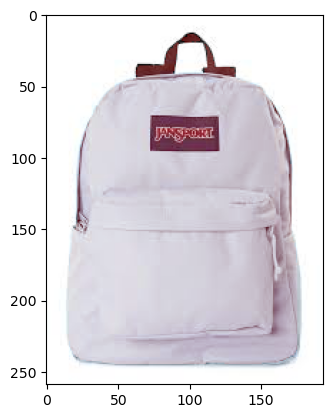

In [21]:
#CHANGE FROM ABOVE
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
color_name = "pink" #CHANGE COLOR
text=["pink backpack"] #CHANGE TEXT
color_name =  color_name.replace(" ", "")
newColor = get_rgb_from_color_name(color_name)
image = colorChange3(newColor, image)
plt.imshow(image)
img = Image.fromarray(image, "RGB")
local_pic = img.save("colorChanged.jpeg")
local_pic =  '/Users/meagankenney/IMA Bootcamp/Ebay/VisualSearch/colorChanged.jpeg' #Insert image directory
common_ids_ordered, df = clip_search_image_and_text(local_pic, text)

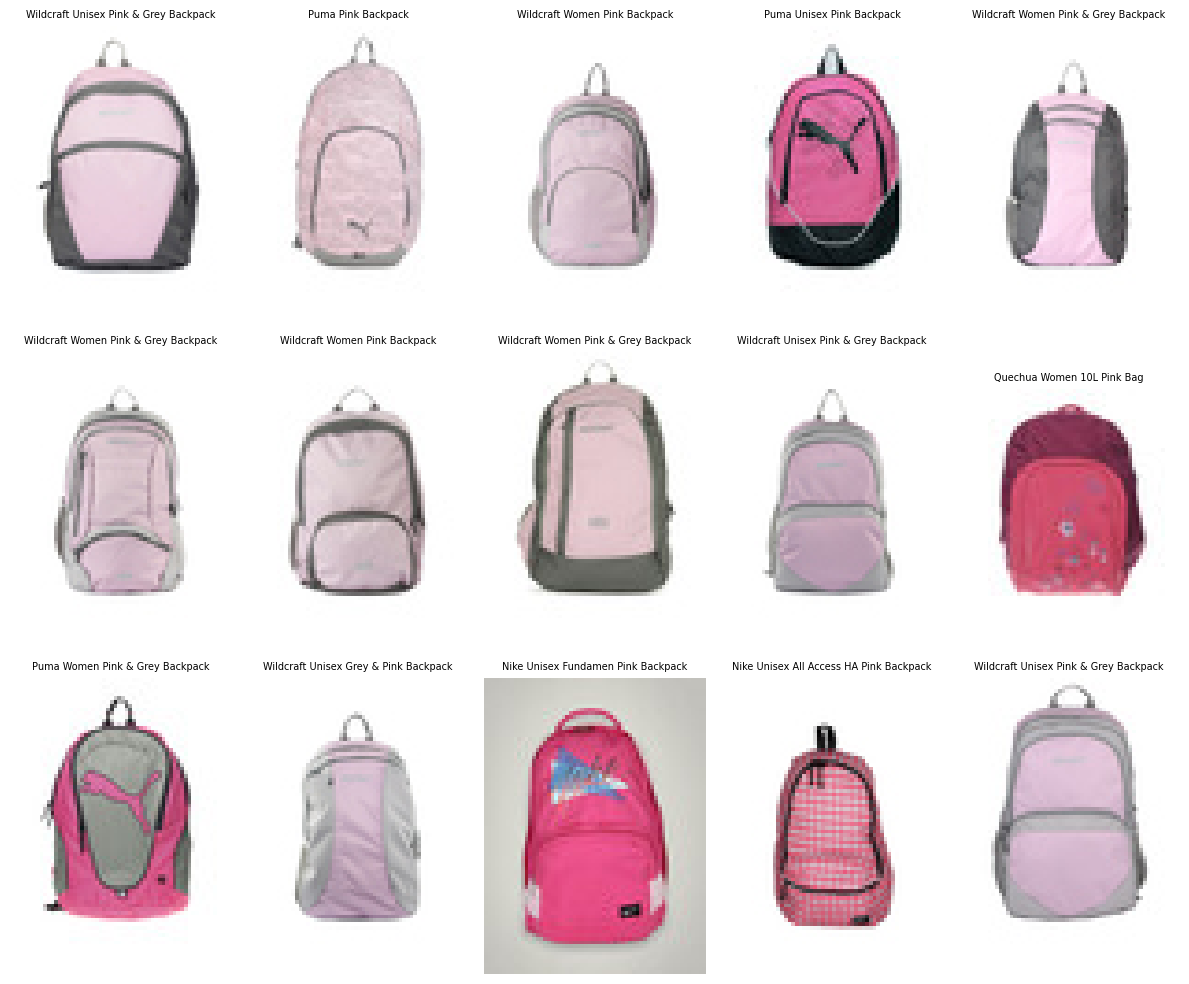

In [22]:
directory = "/Users/meagankenney/IMA Bootcamp/Ebay/myntradataset/images/"
display_images_titles_from_ids(common_ids_ordered, directory, df)